In [ ]:
# !pip install mediapipe
# !git config --global http.sslVerify false
# !pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
import glob
origin_data = glob.glob(r"archive/Videos/*")
print(len(origin_data))

In [ ]:
import tensorflow as tf

In [ ]:
origin_data_violent = glob.glob(r"archive/Videos/Violent_*")
origin_data_normal = glob.glob(r"archive/Videos/Normal_*")
print(len(origin_data_violent))
print(len(origin_data_normal))

In [24]:
import cv2
import tensorflow as tf
from keras.layers import LSTM, Dense,Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras.models import Sequential, load_model
import math
import mediapipe as mp
from mediapipe.python.solutions import pose as mp_pose
import torch
from threading import Thread
import pandas as pd
import numpy as np
from threading import Thread

In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5n')
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

Lấy keypoint 1 video

In [ ]:
# index_global = 0
def EachVideo(linkVideo): # This function is used to cycle through a video
    X = []
    video_path =r""+ linkVideo  # The path to the data file I use
    print(f"playing : {video_path}")
    cap = cv2.VideoCapture(video_path)
    skipTime  = 0
    skipFrame = 0
    while True:    
        ret, frame = cap.read()
        skipTime = skipTime +1
        if not ret:
            break
        if 1==1:
#         if skipTime >= 30: # When skipTime has passed the first 30 frames, ie the first 1 second, proceed to Detect Person
            skipFrame = skipFrame +1 # The variable skipFrame means that every 5 frames I will detect 1 time, so in 1 second I will detect 6 times
            # print(skipFrame)
#             if  skipFrame  == 5: # When skipFrame = 5, I will detect person and assign skipFrame = 0 to run again
            if 1==1:
                skipFrame = 0
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame.flags.writeable = False  
                result = yolo_model(frame)     # Detect Person
                frame.flags.writeable = True   
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                for (xmin, ymin, xmax,   ymax,  confidence,  clas) in result.xyxy[0].tolist(): # Loop through all the Persons present in the video, giving the x,y of each Person
                    c_lm = []
                    with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
                            
#                             frame.flags.writeable = False  

                            resulta = pose.process(frame[int(ymin):int(ymax),int(xmin):int(xmax):])
#                             frame.flags.writeable = True   

                            if resulta.pose_landmarks and clas ==0: # class here is class, class = 0 means human
                                for (id, lm) in enumerate(resulta.pose_landmarks.landmark):
                                    if id > 10 and id not in [17,18,19,20,21,22] and id not in [29,30,31,32] :
                                        c_lm.append(lm.x)
                                        c_lm.append(lm.y)
#                                         c_lm.append(lm.z)
#                                         c_lm.append(lm.visibility)
                    if len(c_lm) > 0: # c_ lm used to save a person's x and y variables in a loop through each person, when saving, there will be a state that there is no x,y data to save 
                        X.append(c_lm) # with linkVideo being violent, we add data to X_violent
#                 if cv2.waitKey(1) & 0xFF == ord('q'):
#                       break
    return X
    cap.release()
    cv2.destroyAllWindows()

### Loop through multiple videos to get keypoint

In [ ]:
def AllVideo(startt,endd,dataset): # This function is used to cycle through all videos
# Status (linkVideo) is : violent, non-violent
    X = []
    
# cam (camIndex) is : cam1 or cam2
# number of videos is : from startt to endd, for example non-violent dataset is startt 1->61 with cam 1, violent from 1 to 115 with cam 1
    for id,i in enumerate(range(startt,endd)):
        print(f'{startt} -> {endd} ## index: {startt+id}')
        X.extend(EachVideo(dataset[i])) # Implement the function to detect
    return X

### Save keypoint, run getData function to run multiple videos at the same time (threading) to get keypoint

In [ ]:
X = []
def getData(startt,endd,origin_data):
    global X
    X = AllVideo(startt,endd,origin_data)

    
# active = []
# skipT = 1500
# for i in range(0,10):
#     active_1 = Thread(target=getData,args=(skipT,skipT+20,origin_data_normal))
#     skipT = skipT + 20
#     active.append(active_1)

# for i in active:
#     i.start()
# for i in active:
#     i.join()

getData(1500, 1700, origin_data_normal)

print(len(X))
X = np.array(X)
print(X.shape)



# X = []
# def getData(startt,endd,origin_data):
#     global X
#     X = AllVideo(startt,endd,origin_data)

    
# active = []
# skipT = 0
# for i in range(0,10):
#     active_1 = Thread(target=getData,args=(skipT,skipT+20,origin_data_violent))
#     skipT = skipT + 20
#     active.append(active_1)

# for i in active:
#     i.start()
# for i in active:
#     i.join()
    
# print(len(X))
# X = np.array(X)
# print(X.shape)

In [ ]:
print(len(X))
Xt = np.array(X)
print(Xt.shape)

### Save keypoint to file

In [ ]:
Xt = pd.DataFrame(Xt)
Xt  = np.nan_to_num(Xt) # Khi đã có dữ liệu, sẽ có một số phần từ trong dữ liệu bị NaN, nên chuyển thành 0
Xt = pd.DataFrame(Xt)
Xt.to_csv("./normal_test.csv")

### Data Crane

Model 1

In [ ]:
# violent_test = pd.read_csv("voilent_0_650_final.csv")

normal_test = pd.read_csv("normal_test.csv")

X = []
y = []

# X_violent = violent_test.iloc[:,1:].values
# len_X_violent = len(X_violent)
# for i in range(10,len_X_violent):
#     X.append(X_violent[i-10:i,:])
#     y.append(1)
    
    
X_non_violent = normal_test.iloc[:,1:].values
len_X_non_violent = len(X_non_violent)
for i in range(10,len_X_non_violent):
    X.append(X_non_violent[i-10:i,:])
    y.append(0)
    
    
X = np.array(X)
y = np.array(y)    
# print(violent_test.shape)
print(normal_test.shape)
print(X.shape)
print(y.shape)



In [ ]:
X[0].shape

In [26]:
model = load_model("models/first.h5")


In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X, y)

In [ ]:
model.predict(X[0].reshape(-1, 10, 24))

In [ ]:
# inference
model = load_model("models/pb_model/")

def inference(linkVideo): # This function is used to cycle through a video
    X = []
    idx = 0
    alert_count = 0
    video_path = linkVideo  # The path to the data file I use
    print(f"playing : {video_path}")
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    size = (frame_width, frame_height)

    # Below VideoWriter object will create
    # a frame of above defined The output 
    # is stored in 'filename.avi' file.
    result_writer = cv2.VideoWriter('filename.avi', 
                             cv2.VideoWriter_fourcc(*'MJPG'),
                             10, size)
    skipTime  = 0
    skipFrame = 0
    while True:    
        ret, frame = cap.read()
        skipTime = skipTime +1
        if not ret:
            break
        if 1==1:
#         if skipTime >= 30: # When skipTime has passed the first 30 frames, ie the first 1 second, proceed to Detect Person
            skipFrame = skipFrame +1 # The variable skipFrame means that every 5 frames I will detect 1 time, so in 1 second I will detect 6 times
            # print(skipFrame)
#             if  skipFrame  == 5: # When skipFrame = 5, I will detect person and assign skipFrame = 0 to run again
            if 1==1:
                skipFrame = 0
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame.flags.writeable = False  
                result = yolo_model(frame)     # Detect Person
                frame.flags.writeable = True   
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                for (xmin, ymin, xmax,   ymax,  confidence,  clas) in result.xyxy[0].tolist(): # Loop through all the Persons present in the video, giving the x,y of each Person
                    c_lm = []
                    with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
                            
#                             frame.flags.writeable = False  

                            resulta = pose.process(frame[int(ymin):int(ymax),int(xmin):int(xmax):])
#                             frame.flags.writeable = True   

                            if resulta.pose_landmarks and clas == 0: # class here is class, class = 0 means human
                                for (id, lm) in enumerate(resulta.pose_landmarks.landmark):
                                    if id > 10 and id not in [17,18,19,20,21,22] and id not in [29,30,31,32] :
                                        c_lm.append(lm.x)
                                        c_lm.append(lm.y)
#                                         c_lm.append(lm.z)
#                                         c_lm.append(lm.visibility)
                    if len(c_lm) > 0: # c_ lm used to save a person's x and y variables in a loop through each person, when saving, there will be a state that there is no x,y data to save 
                        X.append(c_lm) # with linkVideo being violent, we add data to X_violent
                
                    if len(X) >= idx+10:
                        X_inp = np.array(X[idx:idx+10])
                        pred = model.predict(X_inp.reshape(-1, 10, 24))
                        print(pred[0][0])
                        if pred[0][0] > 0.50:
                            # cv2.putText(frame, str(pred[0][0]), (10, 10), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),3)
                            alert_count += 1
                        else:
                            alert_count = 0
                        idx +=1
        if alert_count > 5:
            cv2.putText(frame, "Aggression Behaviour Detected!!!", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 2,(0,0,255),3)
        
        result_writer.write(frame)
        cv2.imshow("pose", frame)        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        cv2.destroyAllWindows()

    cap.release()
    result_writer.release()
    cv2.destroyAllWindows()

In [ ]:
video = 0#"/Users/neo/Downloads/AB2.mp4"

inference(video)

In [18]:
lst = [[0.7699176073074341, 0.19481432437896729, 0.5611128807067871, 0.22867439687252045, 0.6571943759918213, 0.3317640423774719, 0.4230298697948456, 0.3323039412498474, 0.49991655349731445, 0.22421276569366455, 0.34415504336357117, 0.2337348759174347, 0.7032572627067566, 0.4559857249259949, 0.6076101064682007, 0.4639747738838196, 0.26415306329727173, 0.4007982015609741, 0.5575037002563477, 0.6610302329063416, 0.2519151568412781, 0.6272770166397095, 0.7672494053840637, 0.86176997423172], [0.8002002835273743, 0.18507182598114014, 0.6590595841407776, 0.21902433037757874, 0.7291820049285889, 0.3324247896671295, 0.5574362277984619, 0.3257876932621002, 0.5770357251167297, 0.23748062551021576, 0.5008056163787842, 0.25796061754226685, 0.763862669467926, 0.4382103681564331, 0.7009424567222595, 0.45691877603530884, 0.4155151844024658, 0.36088335514068604, 0.6360172629356384, 0.6626571416854858, 0.23995018005371094, 0.5761902332305908, 0.8091439008712769, 0.8645716905593872], [0.7171511650085449, 0.18791154026985168, 0.5591759085655212, 0.21526306867599487, 0.6272274255752563, 0.33659082651138306, 0.433452844619751, 0.33109766244888306, 0.3901101350784302, 0.2444138526916504, 0.3178172707557678, 0.2811466157436371, 0.6972371339797974, 0.4382787346839905, 0.6342501044273376, 0.4626223146915436, 0.28934618830680847, 0.34801188111305237, 0.5316084027290344, 0.6587507128715515, -0.025648117065429688, 0.4831083118915558, 0.7644127607345581, 0.8608119487762451], [0.6893287301063538, 0.19599391520023346, 0.5128780007362366, 0.21790853142738342, 0.6000369191169739, 0.34158289432525635, 0.3215474784374237, 0.3228086829185486, 0.3397133946418762, 0.2577214241027832, 0.21499738097190857, 0.2812578082084656, 0.6812333464622498, 0.43637919425964355, 0.5968048572540283, 0.4524202048778534, 0.21586015820503235, 0.3585386574268341, 0.5283343195915222, 0.6568543314933777, -0.1270851492881775, 0.46344268321990967, 0.7503399848937988, 0.8633987903594971], [0.6955459117889404, 0.20055142045021057, 0.5212627649307251, 0.21825098991394043, 0.549759566783905, 0.33697789907455444, 0.30090826749801636, 0.3168599009513855, 0.32415109872817993, 0.23848530650138855, 0.24736282229423523, 0.25915658473968506, 0.6371828317642212, 0.4478946924209595, 0.5727012753486633, 0.464826375246048, 0.24603480100631714, 0.33000892400741577, 0.5513866543769836, 0.6733344793319702, -0.10839593410491943, 0.42913538217544556, 0.7684546709060669, 0.8761069774627686], [0.7889373302459717, 0.2048453390598297, 0.6260793209075928, 0.22049082815647125, 0.6409932971000671, 0.3373645544052124, 0.4748993515968323, 0.31221434473991394, 0.5018362998962402, 0.2333289086818695, 0.4510005712509155, 0.25470805168151855, 0.7270090579986572, 0.4494051933288574, 0.6558668613433838, 0.46449020504951477, 0.3966815173625946, 0.33331865072250366, 0.6576957106590271, 0.670881986618042, 0.07779788970947266, 0.5056755542755127, 0.8354631662368774, 0.868228554725647], [0.7396079897880554, 0.19530317187309265, 0.5498781800270081, 0.21832185983657837, 0.5418987274169922, 0.324590802192688, 0.4135075509548187, 0.318592369556427, 0.3766399025917053, 0.21714730560779572, 0.33547070622444153, 0.2502281069755554, 0.6620655059814453, 0.4514329731464386, 0.5852506756782532, 0.46653875708580017, 0.25749480724334717, 0.34477782249450684, 0.5664358139038086, 0.6659743189811707, 0.021802246570587158, 0.54973965883255, 0.7913979887962341, 0.8634072542190552], [0.7037594318389893, 0.19721606373786926, 0.5027710199356079, 0.21063736081123352, 0.44926005601882935, 0.330055296421051, 0.3609119653701782, 0.3215879201889038, 0.28871551156044006, 0.2161647528409958, 0.27636072039604187, 0.2412261962890625, 0.6272782683372498, 0.4502488076686859, 0.5420613884925842, 0.45198962092399597, 0.13730564713478088, 0.37792515754699707, 0.5276956558227539, 0.6622517108917236, -0.016354084014892578, 0.5867432355880737, 0.7637906074523926, 0.8618974685668945], [0.5854372382164001, 0.1862086057662964, 0.32613736391067505, 0.22003135085105896, 0.5611717104911804, 0.2939192056655884, 0.11588329076766968, 0.2197476029396057, 0.3728986978530884, 0.20415303111076355, 0.18089723587036133, 0.09843826293945312, 0.5303086042404175, 0.4796312153339386, 0.4474417269229889, 0.4827785789966583, 0.3328123688697815, 0.6714822053909302, 0.576732337474823, 0.683230996131897, 0.2963668704032898, 0.9070543050765991, 0.8202749490737915, 0.8387964963912964]]
lst.append(lst[5])


In [20]:
import numpy as np
la = np.array(lst)

In [21]:
la.shape

(10, 24)

In [27]:
pred = model.predict(la.reshape(-1, 10, 24))

1/1 [==============================] - 1s 872ms/step


In [28]:
pred[0][0]

0.23981388

In [1]:
import json

In [3]:
st = {"objects":[{"detection":{"bounding_box":{"x_max":0.5107938051223755,"x_min":0.2977558374404907,"y_max":0.9771633446216583,"y_min":0.03176644444465637},"confidence":0.9937620759010315,"label_id":1},"h":446,"id":1,"region_id":275,"tensors":[{"confidence":0.9937620759010315,"label_id":1,"layer_name":"detection_out","layout":"ANY","model_name":"person-vehicle-bike-detection-2002","name":"detection","precision":"UNSPECIFIED"},{"layout":"ANY","name":"object_id","precision":"UNSPECIFIED"},{"data":[0.39270099997520447,0.10869564861059189,0.39270099997520447,0.08695652335882187,0.338535338640213,0.08695652335882187,0.5551979541778564,0.08695652335882187,0.501032292842865,0.08695652335882187,0.5551979541778564,0.15217392146587372,0.6635292768478394,0.15217392146587372,0.28436967730522156,0.260869562625885,0.44686663150787354,0.30434784293174744,0.17603838443756104,0.15217392146587372,0.28436967730522156,0.260869562625885,0.6093636155128479,0.4565217196941376,0.7176949381828308,0.4565217196941376,0.28436967730522156,0.6521739363670349,0.6635292768478394,0.6739130616188049,0.338535338640213,0.9130434393882751,0.9343575239181519,0.8695651888847351],"dims":[17,2],"format":"keypoints","layer_name":"heatmaps","layout":"ANY","model_name":"torch-jit-export","name":"classification_layer_name:heatmaps","point_connections":["shoulder_l","shoulder_r","nose","eye_l","nose","eye_r","eye_l","ear_l","eye_r","ear_r","elbow_l","shoulder_l","elbow_r","shoulder_r","wrist_l","elbow_l","wrist_r","elbow_r","hip_l","knee_l","hip_r","knee_r","knee_l","ankle_l","knee_r","ankle_r"],"point_names":["nose","eye_l","eye_r","ear_l","ear_r","shoulder_l","shoulder_r","elbow_l","elbow_r","wrist_l","wrist_r","hip_l","hip_r","knee_l","knee_r","ankle_l","ankle_r"],"precision":"FP32"}],"w":179,"x":250,"y":15}],"resolution":{"height":472,"width":840},"timestamp":800000000}


In [9]:
pp = json.dumps(st, indent=4)

In [10]:
print(pp)

{
    "objects": [
        {
            "detection": {
                "bounding_box": {
                    "x_max": 0.5107938051223755,
                    "x_min": 0.2977558374404907,
                    "y_max": 0.9771633446216583,
                    "y_min": 0.03176644444465637
                },
                "confidence": 0.9937620759010315,
                "label_id": 1
            },
            "h": 446,
            "id": 1,
            "region_id": 275,
            "tensors": [
                {
                    "confidence": 0.9937620759010315,
                    "label_id": 1,
                    "layer_name": "detection_out",
                    "layout": "ANY",
                    "model_name": "person-vehicle-bike-detection-2002",
                    "name": "detection",
                    "precision": "UNSPECIFIED"
                },
                {
                    "layout": "ANY",
                    "name": "object_id",
                    "precision":

In [40]:
pose_data = pose_data[0]['tensors'][2]['data']

In [50]:
c_lm = [] 
for (id, lm) in enumerate(pose_data):
    # print(id)
    if id > 9:# and id not in [18,19,20,21,22] and id not in [29,30,31,32] :
        c_lm.append(lm)

In [68]:
c_lm[0]

0.5551979541778564

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = np.zeros([3, 840,472],dtype=np.uint8)
img.fill(255) 

for i in range(0, 24):
    cv2.circle(img, (c_lm[i], c_lm[i+1]), 20, (255, 0, 0), 2)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


ValueError: x and y can be no greater than 2-D, but have shapes (3,) and (3, 840, 472)

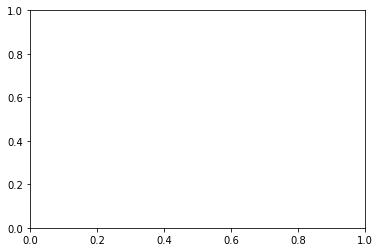

In [63]:
plt.plot(img)
plt.show()

In [48]:
"nose",0-1
"eye_l",2-3
"eye_r",4-5
"ear_l",6-7
"ear_r",8-9

"shoulder_l",10-11 y
"shoulder_r",12-13 y
"elbow_l",14-15 y
"elbow_r",16-17 y
"wrist_l",18-19 y
"wrist_r",20-21 y
"hip_l",22-23 y
"hip_r",24-25 y
"knee_l",26-27 y
"knee_r",28-29 y
"ankle_l",20-31 y
"ankle_r",32-33 y

('ankle_r', -1)

In [ ]:
11. left_shoulder
12. right_shoulder
13. left_elbow
14. right_elbow
15. left_wrist
16. right_wrist
23. left_hip
24. right_hip
25. left_knee
26. right_knee
27. left_ankle
28. right_ankle